Choose the kernel called research

In [1]:
import ipykernel
import os
from io import StringIO
import copy

import statsmodels.formula.api as smf
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import requests

import plotly.graph_objects as go
import statsmodels.formula.api as smf
from plotnine import *
from binsreg import *
import seaborn as sns
from ipumspy import IpumsApiClient, MicrodataExtract, readers, ddi


In [2]:
from pathlib import Path
import time
import datetime
import gc

Load the CPS data from IPUMS

In [3]:
IPUMS_API_KEY = "YOUR API KEY HERE"


In [4]:
# 1. Initialize the IPUMS API client
ipums = IpumsApiClient(IPUMS_API_KEY)

In [16]:
# 2. Define your ATUS data extract
# This is where you specify the collection, samples (years), and variables.
# For a list of all available samples and variables, you can explore the IPUMS website.
atus_extract = MicrodataExtract(
    collection="atus",
    description="ATUS time use by occupation (2021-2024)",
    samples=["at2021", "at2022", "at2023", "at2024"], # Example: select recent years
    variables=[
        "YEAR",
        "WT06",
        "AGE",
        "SEX",
        "EDUC",
        "EMPSTAT",
        "OCC"
        
    ],
    time_use_variables=[
        "ACT_WORK",
        "ACT_PCARE",
        "ACT_HHACT",
        "ACT_SOCIAL"
    ]
)

In [17]:
# 3. Submit the extract request to the IPUMS API
print("Submitting extract request...")
ipums.submit_extract(atus_extract)
print("Request submitted successfully.")

# 4. Wait for the extract to be processed by the IPUMS servers
# This function will check the status periodically and block until the extract is ready.
print("Waiting for extract to be processed...")
ipums.wait_for_extract(atus_extract)
print("Extract is ready for download.")


Submitting extract request...
Request submitted successfully.
Waiting for extract to be processed...
Extract is ready for download.


In [3]:
# 5. Download the data and DDI (codebook) files
# You can specify a download directory.
download_dir = Path("../data")
os.makedirs(download_dir, exist_ok=True)

In [20]:
print(f"Downloading files to {download_dir}...")
ipums.download_extract(atus_extract, download_dir=download_dir)
print("Files downloaded.")

Files downloaded.


In [4]:
# 6. Load the data into a pandas DataFrame using ipumspy
download_files = list(download_dir.glob('*'))

# Identify DDI and data file paths
ddi_file_path = next((p for p in download_files if p.suffix == '.xml'), None)
data_file_path = next((p for p in download_files if p.suffix == '.gz' or p.suffix == '.csv'), None) # .csv if not gzipped by API


In [5]:
print(f"Loading data into Pandas DataFrame...")
# Create a Codebook object from the DDI file
ddi = readers.read_ipums_ddi(ddi_file_path)
# Read the microdata using the codebook
df = readers.read_microdata(ddi, filename=data_file_path)

Loading data into Pandas DataFrame...


/Users/bharat/opt/anaconda3/envs/research/lib/python3.13/site-packages/ipumspy/readers.py:70: CitationWarning: Use of data from IPUMS is subject to conditions including that users should cite the data appropriately.
See the `ipums_conditions` attribute of this codebook for terms of use.
See the `ipums_citation` attribute of this codebook for the appropriate citation.


In [6]:
df

,YEAR,CASEID,SERIAL,PERNUM,LINENO,WT06,AGE,SEX,EDUC,EMPSTAT,OCC,ACT_HHACT,ACT_PCARE,ACT_SOCIAL,ACT_WORK
0,2021,20210101210037,1,1,1,7575483.199036,60,2,21,1,4720,0,450,345,540
1,2021,20210101210081,2,1,1,8737183.466359,30,2,32,1,4700,135,570,330,0
2,2021,20210101210099,3,1,1,30239100.42173,43,1,21,1,6260,60,560,210,505
3,2021,20210101210101,4,1,1,11165507.90082,23,1,40,1,5510,60,670,330,180
4,2021,20210101210109,5,1,1,6562832.761632,20,1,30,1,9640,0,855,390,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33435,2024,20241212242238,7665,1,1,22937529.931575,25,2,40,1,2014,35,508,0,0
33436,2024,20241212242273,7666,1,1,10272309.850973,30,2,31,1,3323,440,800,0,0
33437,2024,20241212242280,7667,1,1,5305071.881987,77,2,31,5,99999,133,630,460,0
33438,2024,20241212242281,7668,1,1,8865700.216005,37,1,40,1,800,0,540,180,0


In [7]:
# Convert relevant columns to numeric, coercing errors
for col in ['AGE', 'WT06', 'ACT_WORK', 'ACT_PCARE', 'ACT_HHACT', 'ACT_SOCIAL']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with missing essential data
df.dropna(subset=['OCC', 'WT06'], inplace=True)

In [8]:
df

,YEAR,CASEID,SERIAL,PERNUM,LINENO,WT06,AGE,SEX,EDUC,EMPSTAT,OCC,ACT_HHACT,ACT_PCARE,ACT_SOCIAL,ACT_WORK
0,2021,20210101210037,1,1,1,7575483.199036,60,2,21,1,4720,0,450,345,540
1,2021,20210101210081,2,1,1,8737183.466359,30,2,32,1,4700,135,570,330,0
2,2021,20210101210099,3,1,1,30239100.42173,43,1,21,1,6260,60,560,210,505
3,2021,20210101210101,4,1,1,11165507.90082,23,1,40,1,5510,60,670,330,180
4,2021,20210101210109,5,1,1,6562832.761632,20,1,30,1,9640,0,855,390,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33435,2024,20241212242238,7665,1,1,22937529.931575,25,2,40,1,2014,35,508,0,0
33436,2024,20241212242273,7666,1,1,10272309.850973,30,2,31,1,3323,440,800,0,0
33437,2024,20241212242280,7667,1,1,5305071.881987,77,2,31,5,99999,133,630,460,0
33438,2024,20241212242281,7668,1,1,8865700.216005,37,1,40,1,800,0,540,180,0


In [9]:
df_employed = df[df['EMPSTAT'] == 1]
df_employed

,YEAR,CASEID,SERIAL,PERNUM,LINENO,WT06,AGE,SEX,EDUC,EMPSTAT,OCC,ACT_HHACT,ACT_PCARE,ACT_SOCIAL,ACT_WORK
0,2021,20210101210037,1,1,1,7575483.199036,60,2,21,1,4720,0,450,345,540
1,2021,20210101210081,2,1,1,8737183.466359,30,2,32,1,4700,135,570,330,0
2,2021,20210101210099,3,1,1,30239100.42173,43,1,21,1,6260,60,560,210,505
3,2021,20210101210101,4,1,1,11165507.90082,23,1,40,1,5510,60,670,330,180
4,2021,20210101210109,5,1,1,6562832.761632,20,1,30,1,9640,0,855,390,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33434,2024,20241212242212,7664,1,1,8531419.694873,27,2,40,1,1108,60,780,292,0
33435,2024,20241212242238,7665,1,1,22937529.931575,25,2,40,1,2014,35,508,0,0
33436,2024,20241212242273,7666,1,1,10272309.850973,30,2,31,1,3323,440,800,0,0
33438,2024,20241212242281,7668,1,1,8865700.216005,37,1,40,1,800,0,540,180,0


In [10]:

# Compute weighted averages of time use variables by year
time_use_vars = ['ACT_WORK', 'ACT_PCARE', 'ACT_HHACT', 'ACT_SOCIAL']

yearly_averages = df_employed.groupby('YEAR').apply(
    lambda x: pd.Series({
        var: np.average(x[var], weights=x['WT06']) 
        for var in time_use_vars
    })
).reset_index()


/var/folders/fh/qql__rq91vd53cv6j4ycymvc0000gn/T/ipykernel_4107/2075173900.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [11]:
# Convert minutes to share of day (24 hours = 1440 minutes)
yearly_averages_share = yearly_averages.copy()
yearly_averages_share[time_use_vars] = yearly_averages_share[time_use_vars] / 1440
yearly_averages_share

,YEAR,ACT_WORK,ACT_PCARE,ACT_HHACT,ACT_SOCIAL
0,2021,0.229937,0.390959,0.064822,0.153030
1,2022,0.220518,0.395073,0.064114,0.154082
2,2023,0.218510,0.396121,0.066348,0.153374
3,2024,0.215677,0.396734,0.068933,0.150381


In [12]:
0.215677 / 0.220518

0.9780471435438378

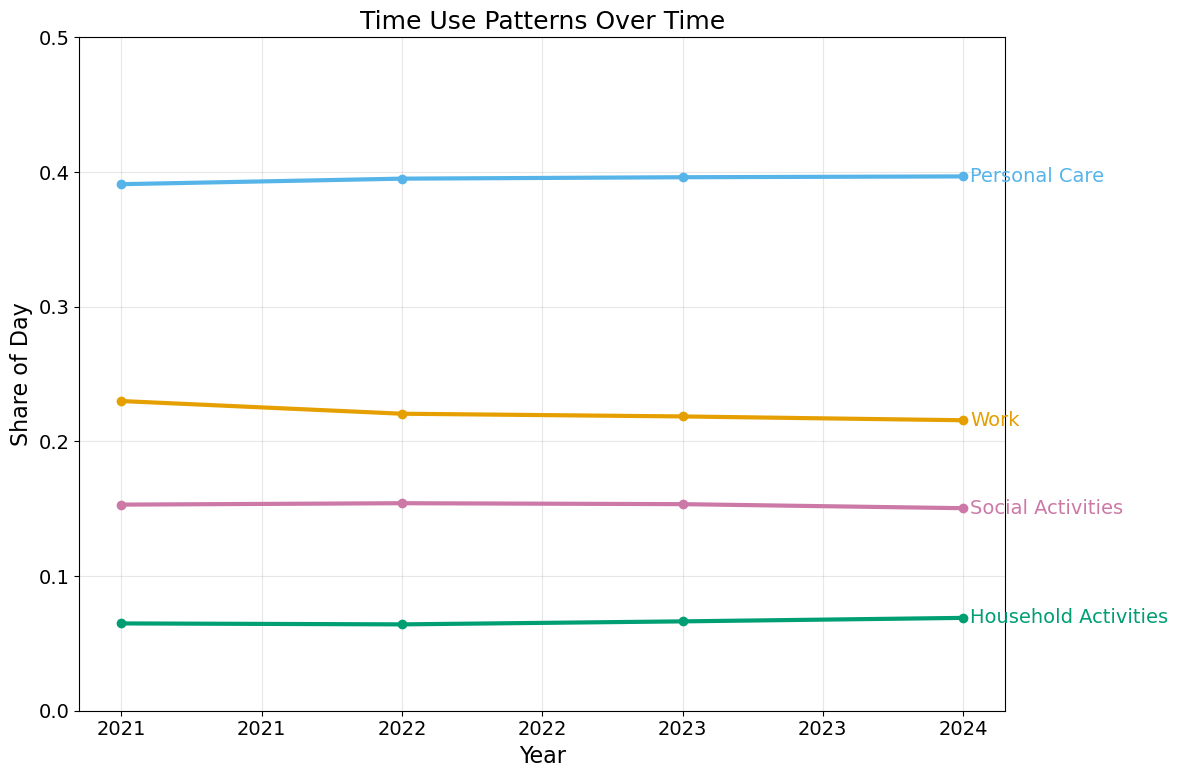

In [ ]:
# Set up the plot style
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Use a colorblind-friendly palette
colors = ['#E69F00', '#56B4E9', '#009E73', '#CC79A7']

# Plot each time use variable and add labels at the end of each line
for i, (var, label) in enumerate([('ACT_WORK', 'Work'), 
                                ('ACT_PCARE', 'Personal Care'),
                                ('ACT_HHACT', 'Household Activities'), 
                                ('ACT_SOCIAL', 'Social Activities')]):
    line = ax.plot(yearly_averages_share['YEAR'], yearly_averages_share[var],
                  color=colors[i], linewidth=3, marker='o')
    # Add label at the end of each line
    x = yearly_averages_share['YEAR'].iloc[-1]
    y = yearly_averages_share[var].iloc[-1]
    ax.annotate(label, xy=(x, y), xytext=(5, 0), textcoords='offset points',
                va='center', color=colors[i])

# Customize the plot
ax.set_xlabel('Year')
ax.set_ylabel('Share of Day')
ax.set_title('Time Use Patterns Over Time')
ax.set_ylim(0, 0.5)
ax.grid(True, alpha=0.3)

# Remove box around figure
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Format x-axis to show years as integers
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: int(x)))

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()


/var/folders/fh/qql__rq91vd53cv6j4ycymvc0000gn/T/ipykernel_4107/2631081120.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


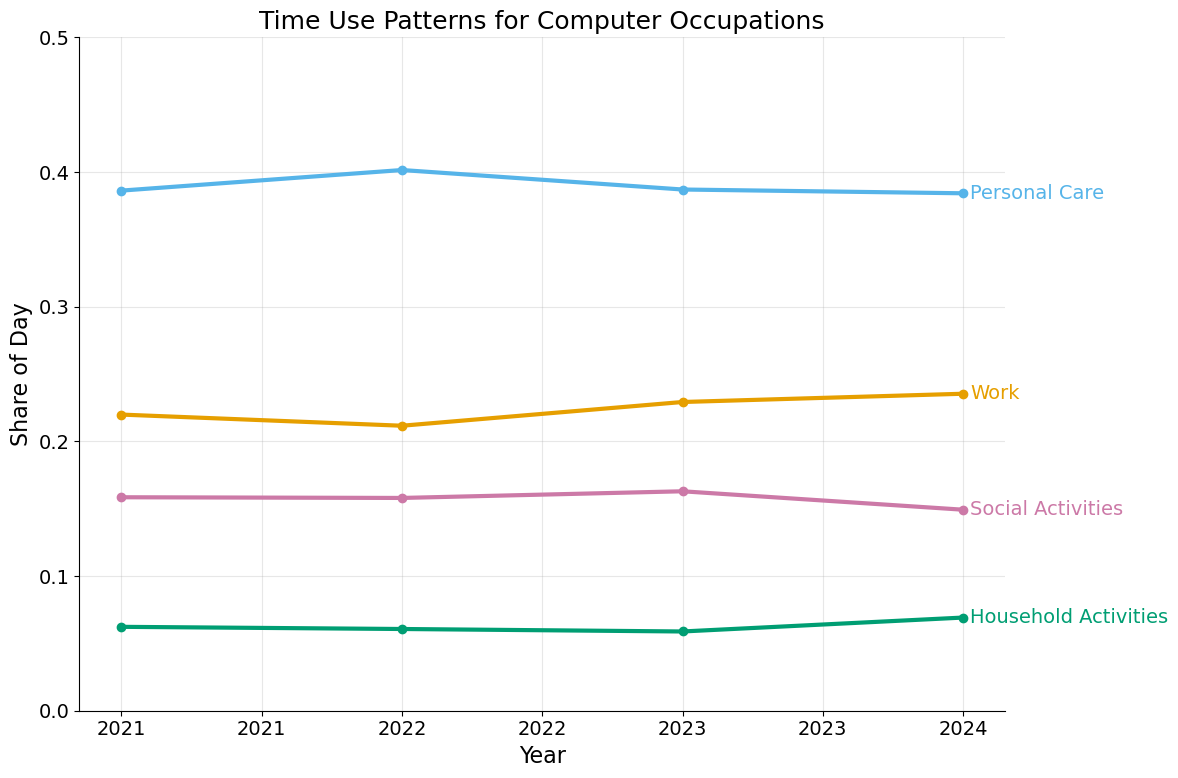

In [15]:
computer_occs = df_employed[df_employed['OCC'].between(1005, 1108)]

# Calculate weighted average time use for computer occupations
computer_time_use = computer_occs.groupby('YEAR').apply(lambda x: pd.Series({
    'ACT_WORK': (x['ACT_WORK'] * x['WT06']).sum() / x['WT06'].sum(),
    'ACT_PCARE': (x['ACT_PCARE'] * x['WT06']).sum() / x['WT06'].sum(),
    'ACT_HHACT': (x['ACT_HHACT'] * x['WT06']).sum() / x['WT06'].sum(),
    'ACT_SOCIAL': (x['ACT_SOCIAL'] * x['WT06']).sum() / x['WT06'].sum()
})).reset_index()

# Convert to shares of day (minutes to fraction of 1440 minutes)
for col in ['ACT_WORK', 'ACT_PCARE', 'ACT_HHACT', 'ACT_SOCIAL']:
    computer_time_use[col] = computer_time_use[col] / 1440

# Create plot for computer occupations
fig, ax = plt.subplots(figsize=(12, 8))

# Remove box around figure
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Use same colorblind-friendly palette
colors = ['#E69F00', '#56B4E9', '#009E73', '#CC79A7']

# Plot each time use variable for computer occupations
for i, (var, label) in enumerate([('ACT_WORK', 'Work'), 
                                ('ACT_PCARE', 'Personal Care'),
                                ('ACT_HHACT', 'Household Activities'), 
                                ('ACT_SOCIAL', 'Social Activities')]):
    line = ax.plot(computer_time_use['YEAR'], computer_time_use[var],
                  color=colors[i], linewidth=3, marker='o')
    # Add label at the end of each line
    x = computer_time_use['YEAR'].iloc[-1]
    y = computer_time_use[var].iloc[-1]
    ax.annotate(label, xy=(x, y), xytext=(5, 0), textcoords='offset points',
                va='center', color=colors[i])

# Customize the plot
ax.set_xlabel('Year')
ax.set_ylabel('Share of Day')
ax.set_title('Time Use Patterns for Computer Occupations')
ax.grid(True, alpha=0.3)
# Set y-axis limit to include 0.5
ax.set_ylim(0, 0.5)

# Format x-axis to show years as integers
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: int(x)))

plt.tight_layout()
plt.show()


## Exposed Occupations

In [76]:

occ_level = pd.read_pickle("../data/occupation_level.pkl")

In [77]:
occ_level["OCC_CODE"] = occ_level["O*NET-SOC Code"].str.slice(start=0, stop=7)

In [78]:
# Load Census to SOC crosswalk
crosswalk = pd.read_excel('../data/2018-occupation-code-list-and-crosswalk.xlsx', sheet_name='2018 Census Occ Code List')


In [79]:

# Drop rows where either occ_census or occ_soc is NaN
crosswalk = crosswalk.drop(columns=['Unnamed: 0']).rename(columns={
    'U.S. Census Bureau': 'occ_title',
    'Unnamed: 2': 'occ_census', 
    'Unnamed: 3': 'occ_soc'
}).dropna(subset=['occ_census', 'occ_soc'])

# Drop first row (header row)
crosswalk = crosswalk.iloc[1:]

# Drop rows where occ_census contains a hyphen
crosswalk = crosswalk[~crosswalk['occ_census'].str.contains('-', na=False)]

# Drop rows where occ_soc is 'none'
crosswalk = crosswalk[crosswalk['occ_soc'] != 'none']




In [80]:
# Get all the wildcard patterns from crosswalk
wildcard_patterns = crosswalk[crosswalk['occ_soc'].str.contains('X')]['occ_soc'].unique()

# First, get all unique OCC_CODEs from occ_level
all_occ_codes = occ_level['OCC_CODE'].unique()

# Create a function to find the matching parent code in crosswalk
def find_parent_code(occ_code):
    occ_code = str(occ_code).zfill(6)
    # Try exact match first
    if occ_code in crosswalk['occ_soc'].values:
        return occ_code
    
    # If still no match, try wildcard patterns
    for pattern in wildcard_patterns:
        pattern = str(pattern).zfill(6)
        if all(p == 'X' or p == o for p, o in zip(pattern, occ_code)):
            return pattern
        
    # If no exact match, try to find the most specific parent code
    # by checking if the code starts with any of the patterns in crosswalk
    matching_patterns = crosswalk[crosswalk['occ_soc'].str.startswith(occ_code[:6])]['occ_soc']
    if not matching_patterns.empty:
        # Get the most specific match (longest pattern)
        return matching_patterns.iloc[0]
    
    matching_patterns = crosswalk[crosswalk['occ_soc'].str.startswith(occ_code[:5])]['occ_soc']
    if not matching_patterns.empty:
        # Get the most specific match (longest pattern)
        return matching_patterns.iloc[0]
    
    matching_patterns = crosswalk[crosswalk['occ_soc'].str.startswith(occ_code[:4])]['occ_soc']
    if not matching_patterns.empty:
        # Get the most specific match (longest pattern)
        return matching_patterns.iloc[0]
    
    return None

# Create a mapping of all OCC_CODEs to their parent codes
occ_code_mapping = {code: find_parent_code(code) for code in all_occ_codes}

# Create a new DataFrame with all the mappings
expanded_crosswalk = pd.DataFrame([
    {
        'occ_title': crosswalk[crosswalk['occ_soc'] == parent_code]['occ_title'].iloc[0] if parent_code else None,
        'occ_soc': code,
        'occ_census': crosswalk[crosswalk['occ_soc'] == parent_code]['occ_census'].iloc[0] if parent_code else None
    }
    for code, parent_code in occ_code_mapping.items()
    if parent_code is not None
])

# Now merge with the original crosswalk
expanded_crosswalk = pd.concat([
    crosswalk,
    expanded_crosswalk[~expanded_crosswalk['occ_soc'].isin(crosswalk['occ_soc'])]
], ignore_index=True)


In [81]:
# Now you can merge with occ_level using the expanded crosswalk
occ_level_with_census = pd.merge(
    occ_level,
    expanded_crosswalk,
    left_on='OCC_CODE',
    right_on='occ_soc',
    how='left'
)

Need to collapse to the 6 digit level, weighting by employment in 2021

In [83]:
# Load occupational employment data from 2021
occ_emp_2021 = pd.read_csv('../data/occupational_employment_2021.txt', sep='\t')

occ_emp_2021['TOT_EMP'] = pd.to_numeric(occ_emp_2021['TOT_EMP'].str.replace(',', ''), errors='coerce')

# Keep only OCC_CODE and TOT_EMP columns
occ_emp_2021 = occ_emp_2021[['OCC_CODE', 'TOT_EMP']]



In [84]:
# Merge with occ_level_with_census
occ_level_with_census = pd.merge(
    occ_level_with_census,
    occ_emp_2021,
    left_on='OCC_CODE',
    right_on='OCC_CODE',
    how='left'
)


In [85]:
# Handle NA values in TOT_EMP
# First fill NA with minimum TOT_EMP for each occ_census group
occ_level_with_census['TOT_EMP'] = occ_level_with_census.groupby('occ_census')['TOT_EMP'].transform(
    lambda x: x.fillna(x.min())
)
# Then fill any remaining NA values with 1
occ_level_with_census['TOT_EMP'] = occ_level_with_census['TOT_EMP'].fillna(1)


In [86]:
# Group by occ_census and compute weighted averages for numeric columns
numeric_cols = ['gpt4_alpha', 'gpt4_beta', 'gpt4_gamma', 'human_alpha', 
                'human_beta', 'human_gamma', 'automation', 'gpt4_alt_beta']

# Create aggregation dictionary
agg_dict = {}
for col in numeric_cols:
    agg_dict[col] = lambda x: np.average(x, weights=occ_level_with_census.loc[x.index, 'TOT_EMP'])

# Add first value aggregation for non-numeric columns
other_cols = [col for col in occ_level_with_census.columns 
              if col not in numeric_cols + ['occ_census', 'TOT_EMP']]
agg_dict.update({col: 'first' for col in other_cols})
agg_dict['TOT_EMP'] = 'sum'

# Perform groupby aggregation
occ_census_agg = occ_level_with_census.groupby('occ_census').agg(agg_dict).reset_index()

In [87]:
# Convert occ_census to numeric
occ_census_agg['occ_census'] = pd.to_numeric(occ_census_agg['occ_census'])

# Calculate quartiles for each measure
measures = ['gpt4_alpha', 'gpt4_beta', 'gpt4_gamma', 'human_alpha', 'human_beta', 
           'human_gamma', 'automation', 'gpt4_alt_beta']

for measure in measures:
    # Calculate quartiles
    quartiles = occ_census_agg[measure].quantile([0.25, 0.5, 0.75])
    
    # Create categorical variable for quartiles
    quartile_col = f'{measure}_quartile'
    occ_census_agg[quartile_col] = pd.qcut(occ_census_agg[measure],
                                          q=4,
                                          labels=['Q1', 'Q2', 'Q3', 'Q4'])


In [88]:
# Merge employment data with occupation codes
full_df = df_employed.merge(
    occ_census_agg, 
    left_on='OCC',
    right_on='occ_census',
    how='inner'
)


In [89]:
exposure_var = 'gpt4_beta_quartile'
exposure_measure = 'gpt4_beta'

In [91]:
# Group by quarter-year and GPT-4 quartile
exposure_time_use = full_df.groupby(['YEAR', exposure_var]).apply(lambda x: pd.Series({
    'ACT_WORK': (x['ACT_WORK'] * x['WT06']).sum() / (x['WT06'].sum() * 1440),
    'ACT_PCARE': (x['ACT_PCARE'] * x['WT06']).sum() / (x['WT06'].sum() * 1440), 
    'ACT_HHACT': (x['ACT_HHACT'] * x['WT06']).sum() / (x['WT06'].sum() * 1440),
    'ACT_SOCIAL': (x['ACT_SOCIAL'] * x['WT06']).sum() / (x['WT06'].sum() * 1440)
})).reset_index()


/var/folders/fh/qql__rq91vd53cv6j4ycymvc0000gn/T/ipykernel_63045/3222025283.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/var/folders/fh/qql__rq91vd53cv6j4ycymvc0000gn/T/ipykernel_63045/3222025283.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


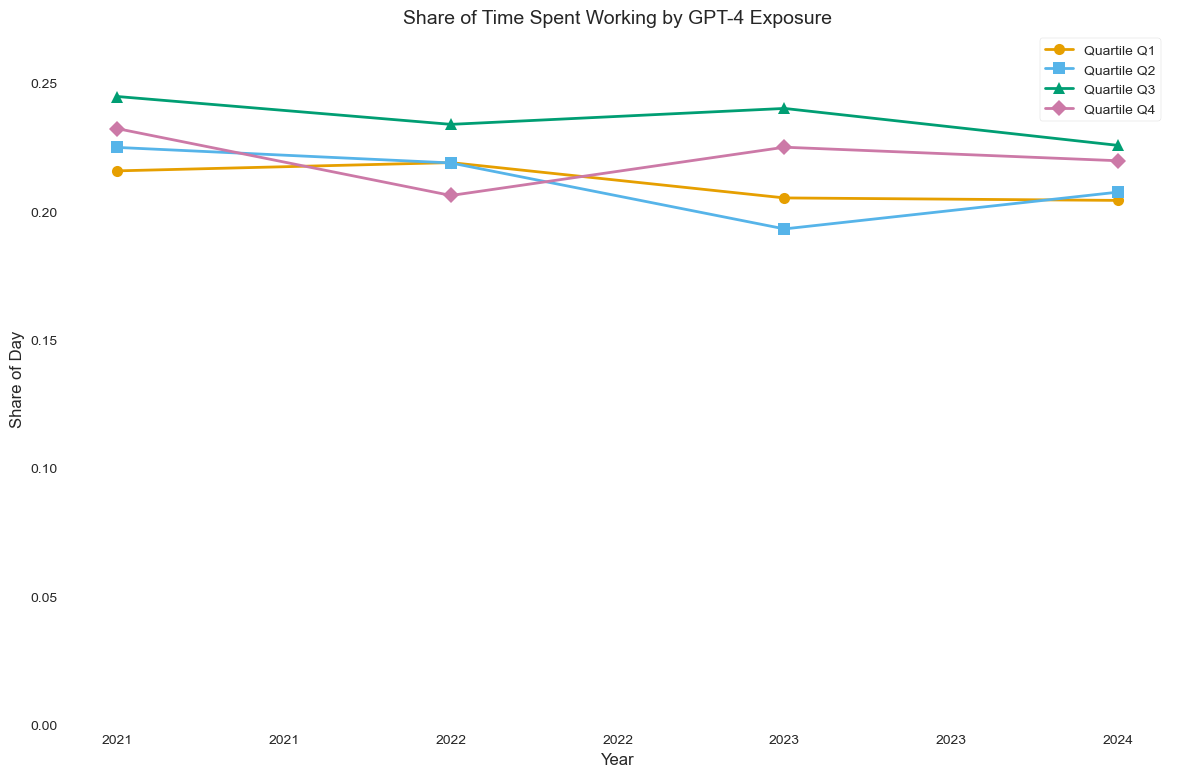

In [96]:
plt.figure(figsize=(12, 8))

# Define colorblind-friendly colors
colors = ['#E69F00', '#56B4E9', '#009E73', '#CC79A7']
markers = ['o', 's', '^', 'D']

# Plot lines for each quartile
for i, quartile in enumerate(['Q1', 'Q2', 'Q3', 'Q4']):
    data = exposure_time_use[exposure_time_use[exposure_var] == quartile]
    plt.plot(data['YEAR'], data['ACT_WORK'],
            color=colors[i],
            marker=markers[i],
            linewidth=2,
            linestyle='-',
            markersize=8,
            label=f'Quartile {quartile}')

# Customize the plot
plt.xlabel('Year', fontsize=16)
plt.ylabel('Share of Day', fontsize=16)
plt.title('Share of Time Spent Working by GPT-4 Exposure', fontsize=18)
plt.grid(True, alpha=0.3)
plt.ylim(0, 0.27)

# Format x-axis to show years as integers
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: int(x)))

# Increase tick label sizes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add legend with larger font
plt.legend(fontsize=14, frameon=True)

plt.tight_layout()
plt.show()
